# Linear regression

In [1]:
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

from sklearn import metrics
from sklearn.linear_model import LinearRegression

from eofs.xarray import Eof

from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Training and testing sets
train_files = ["historical", "ssp126", "ssp370", "ssp585"]
X_train, eof_solvers = create_predictor_data(train_files)

y_train = xr.open_dataset('/data/i4anders/Models/y_train/y_train.nc')

X_test = get_test_data('ssp245', eof_solvers)
y_test = xr.open_dataset('/data/climate-analytics-lab-shared//ClimateBench/CESM2_processed/outputs_ssp245.nc').mean(['month', 'member']).transpose('year', 'lat', 'lon')

In [3]:
X_train.head()

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
0,0.000020,0.039132,-1.070785,-0.107626,-0.571793,-1.272226,-0.051825,-0.348054,-1.280982,-1.068731,-0.392418,-0.362433
1,0.000040,0.039677,-1.070892,-0.104134,-0.577851,-1.246206,-0.069739,-0.344520,-1.280697,-1.061362,-0.404348,-0.379437
2,0.000060,0.040222,-1.073213,-0.117359,-0.553025,-1.242697,-0.067722,-0.346847,-1.278414,-1.057419,-0.402204,-0.379591
3,0.000082,0.040767,-1.075500,-0.130609,-0.528296,-1.238282,-0.065884,-0.348326,-1.276769,-1.054936,-0.401100,-0.380175
4,0.000107,0.041312,-1.087790,-0.214882,-0.368441,-1.335067,0.028653,-0.375174,-1.265988,-1.070907,-0.339490,-0.304372


### Plotting variables weighted vs unweighted

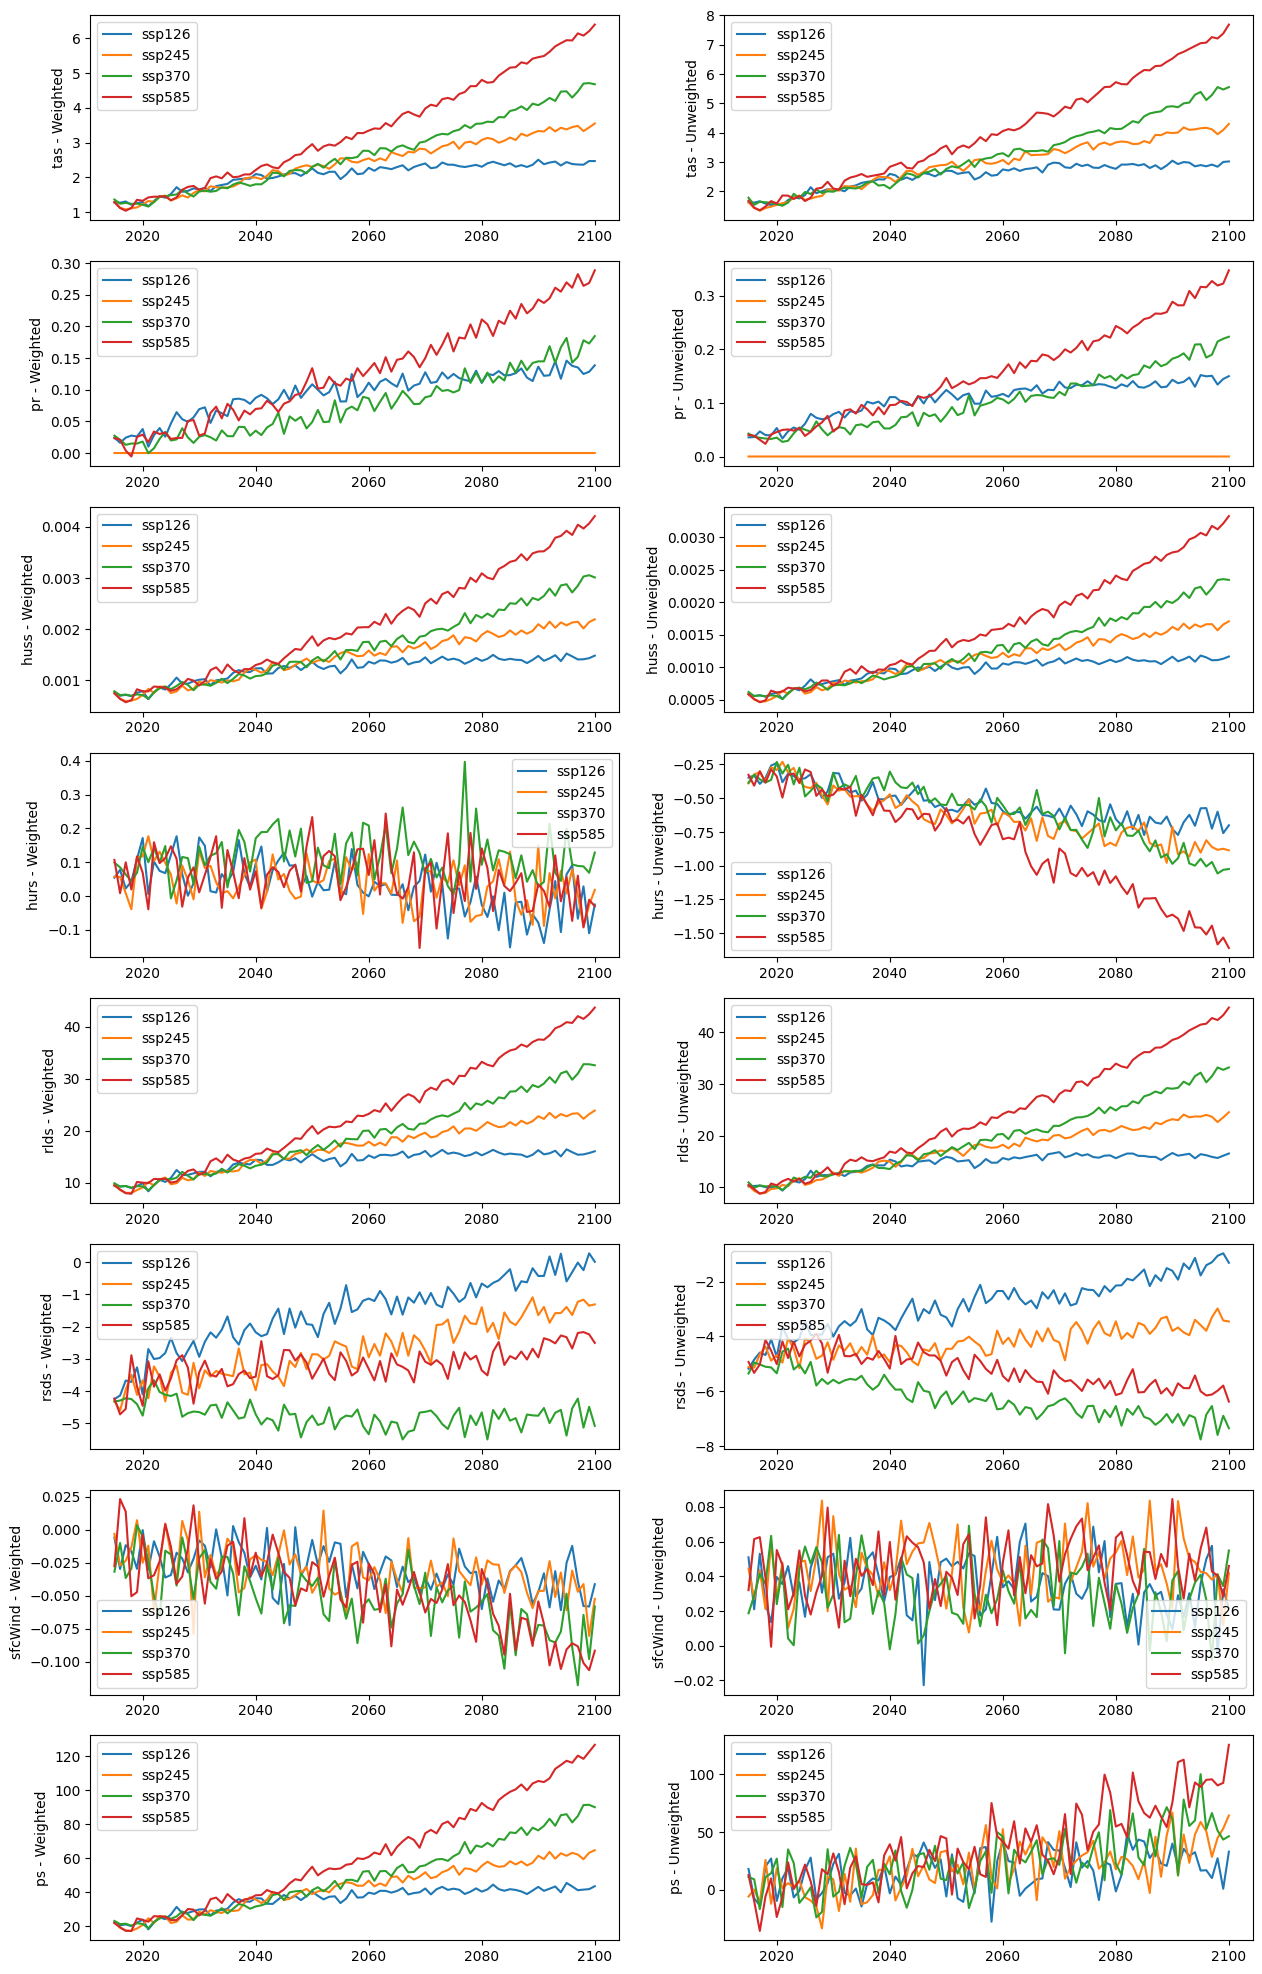

In [4]:
x = range(2015, 2101)
variables = ['tas', 'pr', 'huss', 'hurs', 'rlds', 'rsds', 'sfcWind', 'ps']

fig, axes = plt.subplots(8, 2, figsize=(15,25))
weights = np.cos(np.deg2rad(y_train.lat))

for idx, var in enumerate(variables):
    axes[idx, 0].plot(x, y_train[var][165:165+86].weighted(weights).mean(['lat', 'lon']).data, label='ssp126')
    axes[idx, 0].plot(x, y_test[var][:].weighted(weights).mean(['lat', 'lon']).data, label='ssp245')
    axes[idx, 0].plot(x, y_train[var][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']).data, label='ssp370')
    axes[idx, 0].plot(x, y_train[var][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']).data, label='ssp585')
    axes[idx, 0].legend()
    axes[idx, 0].set_ylabel("{} - Weighted".format(var))
    
    axes[idx, 1].plot(x, y_train[var][165:165+86].mean(['lat', 'lon']).data, label='ssp126')
    axes[idx, 1].plot(x, y_test[var][:].mean(['lat', 'lon']).data, label='ssp245')
    axes[idx, 1].plot(x, y_train[var][165+86:165+86+86].mean(['lat', 'lon']).data, label='ssp370')
    axes[idx, 1].plot(x, y_train[var][165+86+86:165+86+86+86].mean(['lat', 'lon']).data, label='ssp585')
    axes[idx, 1].legend()
    axes[idx, 1].set_ylabel("{} - Unweighted".format(var))


### Regression

In [5]:
# truth values
y_train_tas = y_train['tas'].values.reshape(-1, 192 * 288)
tas_truth = y_test['tas']

y_train_pr = y_train['pr'].values.reshape(-1, 192 * 288)
pr_truth = y_test['pr']

y_train_huss = y_train['huss'].values.reshape(-1, 192 * 288)
huss_truth = y_test['huss']

y_train_hurs = y_train['hurs'].values.reshape(-1, 192 * 288)
hurs_truth = y_test['hurs']

y_train_rlds = y_train['rlds'].values.reshape(-1, 192 * 288)
rlds_truth = y_test['rlds']

y_train_rsds = y_train['rsds'].values.reshape(-1, 192 * 288)
rsds_truth = y_test['rsds']

y_train_wind = y_train['sfcWind'].values.reshape(-1, 192 * 288)
wind_truth = y_test['sfcWind']

y_train_ps = y_train['ps'].values.reshape(-1, 192 * 288)
ps_truth = y_test['ps']

In [6]:
# Dropping rows that contain nan
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
y_train_pr = y_train_pr[~nan_train_mask]
y_train_huss = y_train_huss[~nan_train_mask]
y_train_hurs = y_train_hurs[~nan_train_mask]
y_train_rlds = y_train_rlds[~nan_train_mask]
y_train_rsds = y_train_rsds[~nan_train_mask]
y_train_wind = y_train_wind[~nan_train_mask]
y_train_ps = y_train_ps[~nan_train_mask]
assert len(X_train) == len(y_train_tas) == len(y_train_pr) == len(y_train_huss) == len(y_train_hurs) == len(y_train_rsds) == len(y_train_rlds) == len(y_train_wind) == len(y_train_ps)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]
pr_truth = pr_truth[~nan_test_mask]
huss_truth = huss_truth[~nan_test_mask]
hurs_truth = hurs_truth[~nan_test_mask]
rlds_truth = rlds_truth[~nan_test_mask]
rsds_truth = rsds_truth[~nan_test_mask]
wind_truth = wind_truth[~nan_test_mask]

In [7]:
# X_test

In [8]:
var_names = ['tas', 'pr', 'huss', 'hurs', 'rlds', 'rsds', 'sfcWind', 'ps']
train_vars = [y_train_tas, y_train_pr, y_train_huss, y_train_hurs, y_train_rlds, y_train_rsds, y_train_wind, y_train_ps]
truth_vars = [tas_truth, pr_truth, huss_truth, hurs_truth, rlds_truth, rsds_truth, wind_truth, ps_truth]

for i in range(len(var_names)):
    lr = LinearRegression()
    lr_fit = lr.fit(X_train, train_vars[i])
    l_var = lr_fit.predict(X_test)
    l_out_var = l_var.reshape(86, 192, 288)
    
    print(f"{var_names[i]} rmse values")
    print(f"RMSE at 2050: {get_rmse(truth_vars[i][35], l_out_var[35]).mean()}")
    print(f"RMSE at 2100: {get_rmse(truth_vars[i][85], l_out_var[85]).mean()}")
    print(f"RMSE 2045-2055: {get_rmse(truth_vars[i][30:41], l_out_var[30:41]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(truth_vars[i][75:], l_out_var[75:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(truth_vars[i][35:], l_out_var[35:]).mean()}\n")

tas rmse values
RMSE at 2050: 0.838192292403337
RMSE at 2100: 1.0523104372114918
RMSE 2045-2055: 0.8978690329319252
RMSE 2090-2100: 0.9351118024016055
RMSE 2050-2100: 0.8539787733641242

pr rmse values
RMSE at 2050: 0.40830340753184996
RMSE at 2100: 0.49828437091639544
RMSE 2045-2055: 0.4070829907615254
RMSE 2090-2100: 0.4880392113504508
RMSE 2050-2100: 0.4572382653594109

huss rmse values
RMSE at 2050: 0.0004632469914070572
RMSE at 2100: 0.0006561359533411694
RMSE 2045-2055: 0.0005309674475099204
RMSE 2090-2100: 0.0005956185848879692
RMSE 2050-2100: 0.0005363001891898751

hurs rmse values
RMSE at 2050: 1.1669598030598278
RMSE at 2100: 1.3406969317874218
RMSE 2045-2055: 1.3069153116055927
RMSE 2090-2100: 1.3238550563541114
RMSE 2050-2100: 1.3193224423012662

rlds rmse values
RMSE at 2050: 4.689573388537352
RMSE at 2100: 5.925589741805971
RMSE 2045-2055: 5.179812083585825
RMSE 2090-2100: 5.4103370332623015
RMSE 2050-2100: 5.020137934216945

rsds rmse values
RMSE at 2050: 5.0528368901651